# Practical-11
# Statictiscal Foundation of Data Science
# Alka
# GF202345417

Trying to download from: https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv
Loaded data from https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv  (rows=3322)
Data covers 1749-01-15 to 2025-10-15, 3322 rows


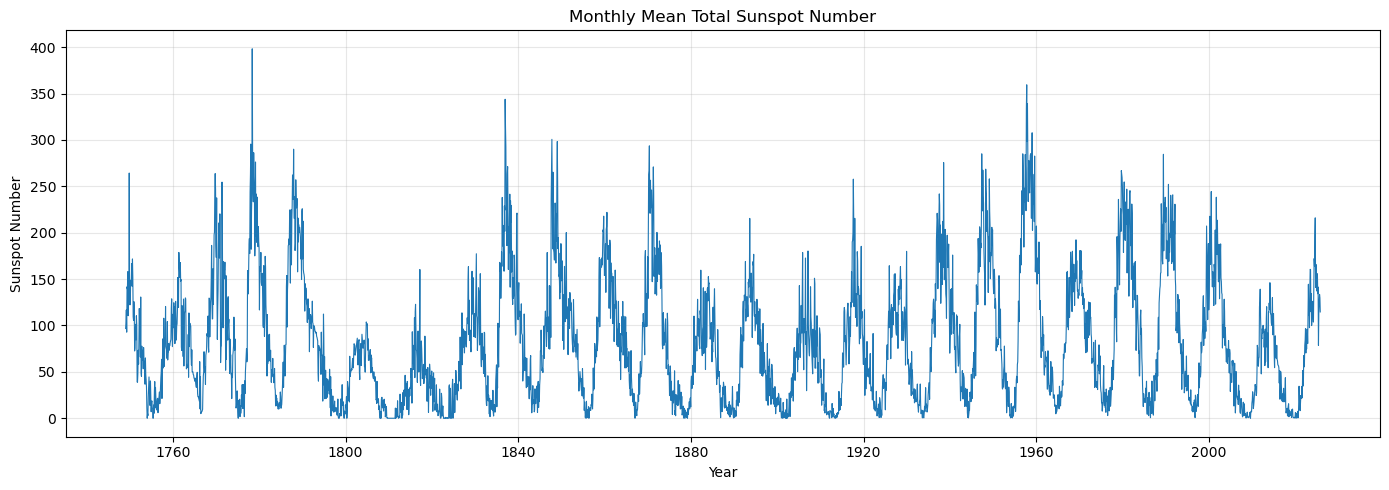

Saved plot to sunspot_timeseries.png


<Figure size 640x480 with 0 Axes>

In [30]:
#Step 1. Plot the data over the years to see what the distribution might be like

import io
import sys
import pandas as pd
import matplotlib.pyplot as plt

# If you already downloaded the CSV, set this to the filename (e.g. "SN_m_tot_V2.0.csv")
LOCAL_PATH = None  # <-- set to a local path if the download fails or you prefer local file

# Primary & alternative URLs (lowercase 'silso' recommended)
URLS = [
    "https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv",
    "https://www.sidc.be/silso/data/SN_m_tot_V2.0.csv",  # alternative case
    "https://www.sidc.be/silso/DATA/sn_m_tot_v2.0.csv"   # sometimes mirrors differ
]

def download_text(url):
    """Try to download text from url using requests, else urllib."""
    try:
        import requests
        r = requests.get(url, timeout=15)
        r.raise_for_status()
        return r.text
    except Exception:
        # fallback to urllib
        try:
            from urllib.request import urlopen
            with urlopen(url, timeout=20) as resp:
                raw = resp.read()
                # try decode as utf-8, fallback to latin1
                try:
                    return raw.decode('utf-8')
                except Exception:
                    return raw.decode('latin1')
        except Exception as e:
            raise RuntimeError(f"Failed to download from {url}: {e}")

def read_csv_flexible(text):
    """Try to guess delimiter and read into pandas DataFrame."""
    # try semicolon first, then comma
    for sep in [';', ',']:
        try:
            df = pd.read_csv(io.StringIO(text), sep=sep, header=None,
                             names=["year","month","decimal_year","sunspot","std","n_obs","indicator"],
                             comment='#', engine='python')
            # require at least 3 columns and that 'sunspot' parsed numeric
            if df.shape[1] >= 3 and pd.to_numeric(df['sunspot'], errors='coerce').notna().sum() > 0:
                return df
        except Exception:
            pass
    # final attempt: whitespace delim
    try:
        df = pd.read_csv(io.StringIO(text), delim_whitespace=True, header=None, engine='python')
        # try to coerce into expected columns if possible
        if df.shape[1] >= 4:
            df = df.iloc[:, :7]
            df.columns = ["year","month","decimal_year","sunspot","std","n_obs","indicator"]
            return df
    except Exception:
        pass
    raise RuntimeError("Could not parse CSV text with common delimiters (; , whitespace).")

def load_dataframe():
    # 1) local file if specified
    if LOCAL_PATH:
        try:
            txt = open(LOCAL_PATH, 'rb').read()
            try:
                text = txt.decode('utf-8')
            except Exception:
                text = txt.decode('latin1')
            return read_csv_flexible(text)
        except Exception as e:
            print(f"Warning: failed to read local file {LOCAL_PATH}: {e}", file=sys.stderr)

    # 2) try each URL until one works
    last_err = None
    for url in URLS:
        try:
            print(f"Trying to download from: {url}")
            text = download_text(url)
            df = read_csv_flexible(text)
            print(f"Loaded data from {url}  (rows={len(df)})")
            return df
        except Exception as e:
            last_err = e
            print(f"  failed: {e}", file=sys.stderr)

    # 3) give up
    raise RuntimeError(f"All download/read attempts failed. Last error: {last_err}")

# --- load ---
df = load_dataframe()

# Keep only needed columns and coerce types
df = df[["year","month","sunspot"]].copy()
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
df['month'] = pd.to_numeric(df['month'], errors='coerce').astype('Int64')
df['sunspot'] = pd.to_numeric(df['sunspot'], errors='coerce')

# drop rows where year/month or sunspot is missing
df = df.dropna(subset=['year','month','sunspot']).reset_index(drop=True)

# Build a date safely (use day=15 to represent the middle of the month)
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-15', errors='coerce')
df = df.dropna(subset=['date']).reset_index(drop=True)

# Basic check
if df.empty:
    raise RuntimeError("Dataframe is empty after parsing. Check the source file.")

print(f"Data covers {df['date'].min().date()} to {df['date'].max().date()}, {len(df)} rows")

# --- STEP 1 plot ---
plt.figure(figsize=(14,5))
plt.plot(df['date'], df['sunspot'], linewidth=0.8)
plt.title("Monthly Mean Total Sunspot Number")
plt.xlabel("Year")
plt.ylabel("Sunspot Number")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save a copy of the plot to file (optional)
out_png = "sunspot_timeseries.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print(f"Saved plot to {out_png}")


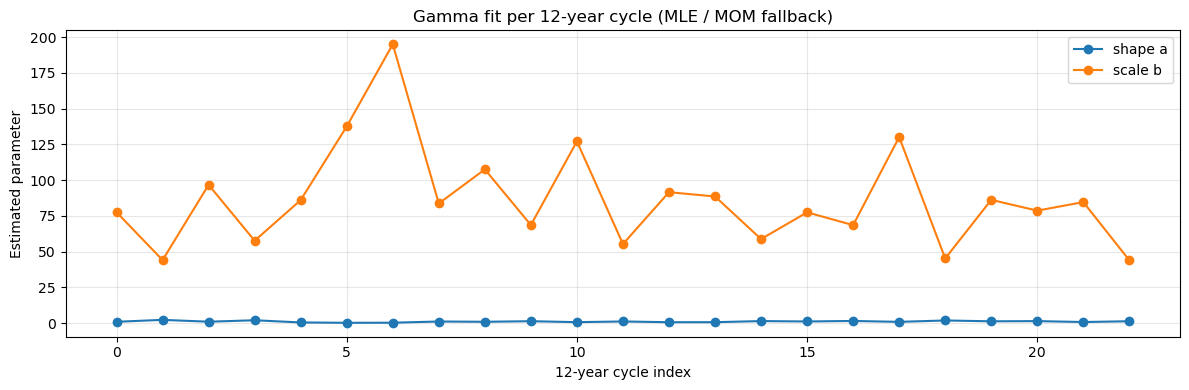

In [13]:
# ----------------------------------------------------
# STEP 2 — Fit gamma distribution every 12-year cycle
# (12 years = 144 months)
# ----------------------------------------------------
cycle_length_months = 12 * 12  # 144
a_list, b_list = [], []
cycle_idx = []

for i in range(0, len(sunspots_pos), cycle_length_months):
    chunk = sunspots_pos[i:i + cycle_length_months]
    if len(chunk) < 10:
        continue
    # gamma.fit can be sensitive if chunk has zeros; using small eps avoids -inf
    try:
        fit_a, fit_loc, fit_b = gamma.fit(chunk, floc=0)  # force loc=0
    except Exception:
        # fallback method-of-moments
        mean = chunk.mean()
        var = chunk.var(ddof=0)
        fit_a = (mean ** 2) / var if var > 0 else np.nan
        fit_b = var / mean if mean > 0 else np.nan
    a_list.append(float(fit_a))
    b_list.append(float(fit_b))
    cycle_idx.append(i // cycle_length_months)

plt.figure(figsize=(12,4))
plt.plot(cycle_idx, a_list, marker='o', label='shape a')
plt.plot(cycle_idx, b_list, marker='o', label='scale b')
plt.xlabel("12-year cycle index")
plt.ylabel("Estimated parameter")
plt.title("Gamma fit per 12-year cycle (MLE / MOM fallback)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

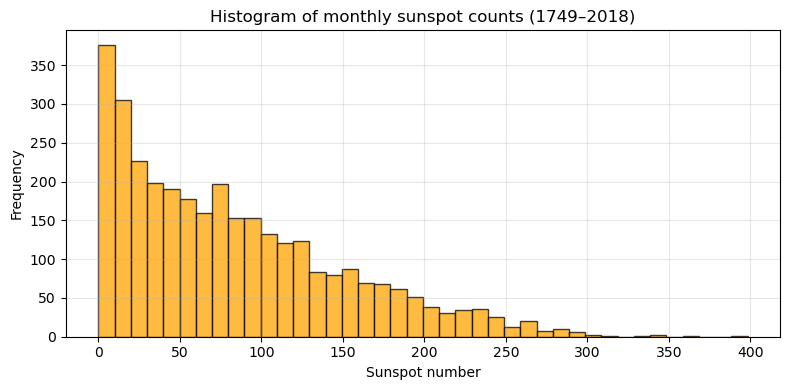

In [7]:
# ----------------------------------------------------
# STEP 3 — Histogram of sunspot counts
# ----------------------------------------------------
plt.figure(figsize=(8,4))
plt.hist(sunspots, bins=40, color='orange', edgecolor='k', alpha=0.75)
plt.title("Histogram of monthly sunspot counts (1749–2018)")
plt.xlabel("Sunspot number")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

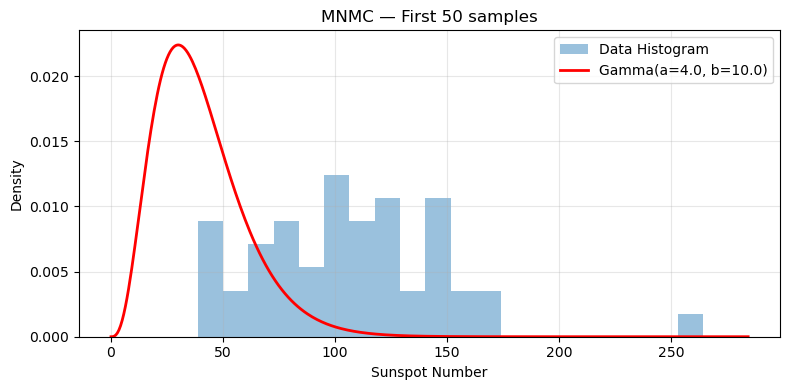

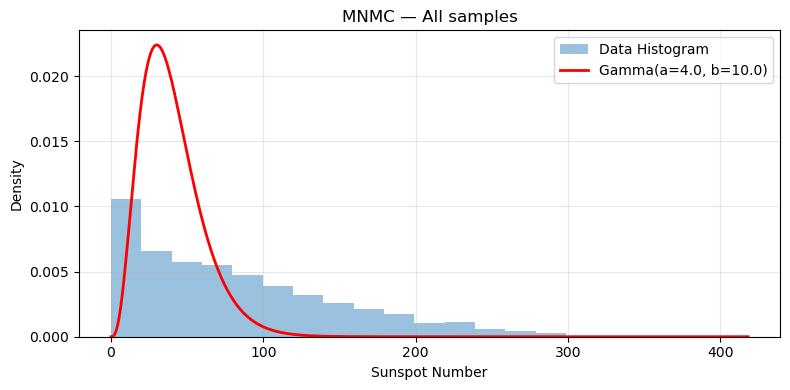

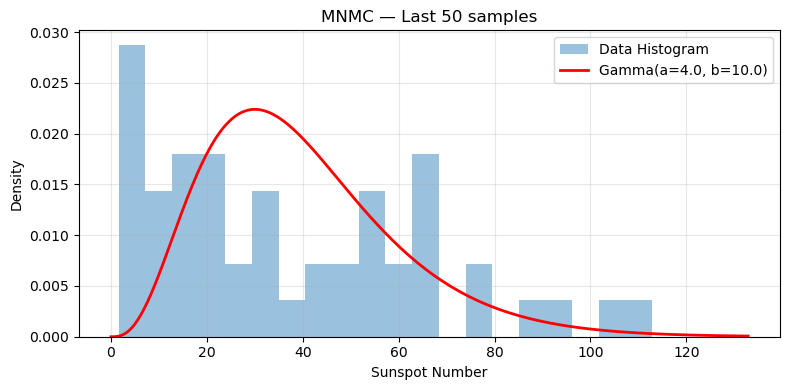

In [19]:
#Step 4. a = 4 and b = 10 so plot MNMC for groups: First 50 samples, All samples, Last 50 samples
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma as sp_gamma

# Fix EPS
EPS = 1e-9

# a = shape, b = scale
a_fixed = 4.0
b_fixed = 10.0

# Function to overlay gamma pdf on histogram
def plot_gamma_overlay(data_slice, title, a=a_fixed, b=b_fixed):
    data_slice = np.array(data_slice)

    # Data must be non-negative
    data_slice = data_slice[data_slice >= 0]

    # X-range for smooth pdf curve
    x_max = max(np.max(data_slice), a * b) + 20
    x = np.linspace(0, x_max, 400)

    # Gamma PDF
    pdf = sp_gamma.pdf(x + EPS, a, scale=b)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.hist(data_slice, bins=20, density=True, alpha=0.45, label="Data Histogram")
    plt.plot(x, pdf, 'r-', lw=2, label=f"Gamma(a={a}, b={b})")
    plt.title(title)
    plt.xlabel("Sunspot Number")
    plt.ylabel("Density")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# Run MNMC Plots
# -------------------------------------------------------

# Ensure you already have sunspots array:
# sunspots = df["sunspot"].values

plot_gamma_overlay(sunspots[:50],  "MNMC — First 50 samples")
plot_gamma_overlay(sunspots,       "MNMC — All samples")
plot_gamma_overlay(sunspots[-50:], "MNMC — Last 50 samples")




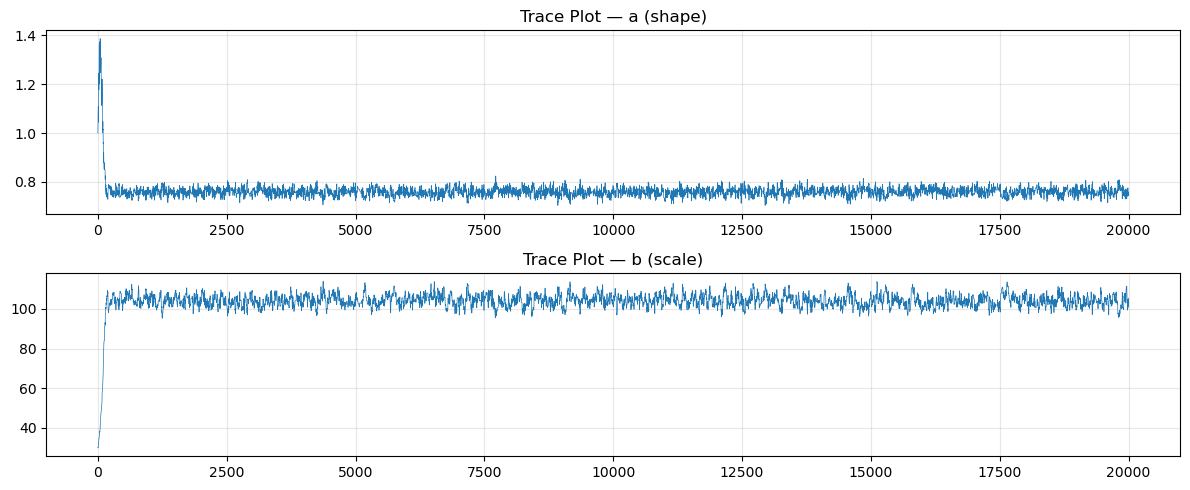

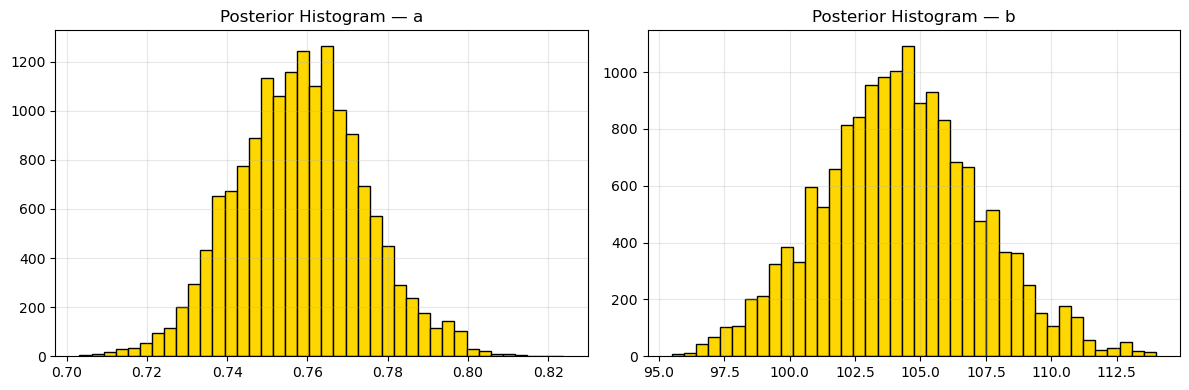

a (shape): mean=0.7583, median=0.7585, std=0.0160, 95% CI=(0.7282, 0.7913)
b (scale): mean=104.2483, median=104.2104, std=3.0223, 95% CI=(98.4201, 110.5615)


In [23]:
# ----------------------------------------------------
# STEP 5 — MCMC VISUALIZATION (TRACE PLOTS + HISTOGRAMS)
# ----------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln

# -------------------------------
# Log-prior
# -------------------------------
def log_prior(a, b):
    if a <= 0 or b <= 0:
        return -np.inf
    return -a - b   # Exponential(1) priors

# -------------------------------
# Log-likelihood (Gamma, loc=0)
# -------------------------------
def log_likelihood(a, b, x):
    if a <= 0 or b <= 0:
        return -np.inf
    return np.sum((a - 1) * np.log(x) - x / b - a * np.log(b) - gammaln(a))

# -------------------------------
# Log-posterior
# -------------------------------
def log_posterior(a, b, x):
    lp = log_prior(a, b)
    if lp == -np.inf:
        return -np.inf
    return lp + log_likelihood(a, b, x)

# -------------------------------
# Metropolis–Hastings MCMC
# -------------------------------
def mcmc_metropolis(x, its=20000, burn=4000, seed=42):
    np.random.seed(seed)

    a_chain = np.zeros(its)
    b_chain = np.zeros(its)

    a_chain[0] = 1.0
    b_chain[0] = 30.0

    prop_a_sigma = 0.05
    prop_b_sigma = 0.02

    for i in range(1, its):

        # propose new values in log-space
        a_prop = np.exp(np.log(a_chain[i-1]) + np.random.normal(scale=prop_a_sigma))
        b_prop = np.exp(np.log(b_chain[i-1]) + np.random.normal(scale=prop_b_sigma))

        lp_old = log_posterior(a_chain[i-1], b_chain[i-1], x)
        lp_prop = log_posterior(a_prop, b_prop, x)

        # accept / reject
        if np.log(np.random.rand()) < (lp_prop - lp_old):
            a_chain[i] = a_prop
            b_chain[i] = b_prop
        else:
            a_chain[i] = a_chain[i-1]
            b_chain[i] = b_chain[i-1]

    return a_chain[burn:], b_chain[burn:], a_chain, b_chain


# ----------------------------------------------------
# Run MCMC (sunspots_pos = dataset without zeros)
# ----------------------------------------------------
a_post, b_post, a_full, b_full = mcmc_metropolis(sunspots_pos, its=20000, burn=4000)


# ----------------------------------------------------
# TRACE PLOTS
# ----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(2,1,1)
plt.plot(a_full, lw=0.5)
plt.title("Trace Plot — a (shape)")
plt.grid(alpha=0.3)

plt.subplot(2,1,2)
plt.plot(b_full, lw=0.5)
plt.title("Trace Plot — b (scale)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ----------------------------------------------------
# HISTOGRAMS (Posterior after burn-in)
# ----------------------------------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(a_post, bins=40, color='gold', edgecolor='black')
plt.title("Posterior Histogram — a")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.hist(b_post, bins=40, color='gold', edgecolor='black')
plt.title("Posterior Histogram — b")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ----------------------------------------------------
# PRINT POSTERIOR SUMMARY
# ----------------------------------------------------
def summarize(samples, name):
    print(f"{name}: mean={np.mean(samples):.4f}, median={np.median(samples):.4f}, "
          f"std={np.std(samples):.4f}, "
          f"95% CI=({np.percentile(samples,2.5):.4f}, {np.percentile(samples,97.5):.4f})")

summarize(a_post, "a (shape)")
summarize(b_post, "b (scale)")


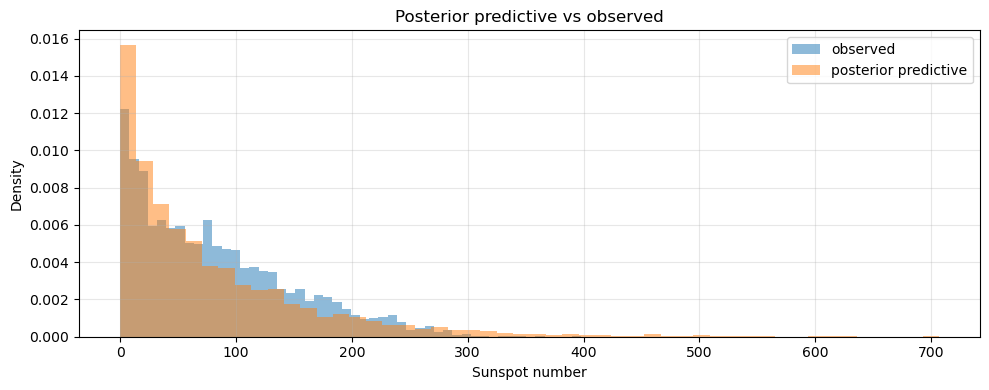

In [24]:
# ----------------------------------------------------
# STEP 6 — Posterior predictive checks (prediction time)
# ----------------------------------------------------
n_pp = 5000
idx = np.random.choice(len(a_post), size=n_pp, replace=True)
pp_samples = sp_gamma.rvs(a_post[idx], scale=b_post[idx], size=n_pp)

plt.figure(figsize=(10,4))
plt.hist(sunspots, bins=50, density=True, alpha=0.5, label='observed')
plt.hist(pp_samples, bins=50, density=True, alpha=0.5, label='posterior predictive')
plt.title("Posterior predictive vs observed")
plt.xlabel("Sunspot number")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
